## Basics

In [1]:
from primitives import Parameters
p = Parameters()
import matplotlib.pyplot as plt
import numpy as np
from plots import Plots
plts=Plots(p)
cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc,mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n1,mwc_s_J,mwc_s_W,mwc_s_Wstar,mwc_s_sep,mwc_s_dir_J,mwc_s_dir_W,mwc_s_dir_Wstar,mwc_s_dir_sep=None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None

In [2]:
from ContinuousContract import ContinuousContract
cc=ContinuousContract(p)
(cc_J,cc_W,cc_Wstar,cc_Jpi,cc_pc)=cc.J(0)

In [3]:
from Multiworker_Contract_all import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
(mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n1)=mwc.J()

Ji shape (1, 9, 9, 100)
W1i shape (1, 9, 9, 100, 2)
Errors: 8.031216820047025 1.071493039190849 30.556127217691962 2.1544606896466805 1
Errors: 0.0 1.071493039190849 30.556127217691962 2.1544606896466805 1
EJinv -19.451014099592047
EJderiv 60.355224776554266
EJinv diff 1j 2s: 1.4093208522971008
EJinv diff 1 sen: 0.37693176025019315
EJinv diff 2 sen: 45.692303542513365
EJinv -5.421551195255676
EJderiv 77.21161457410913
EJinv diff 1j 2s: 1.187220569902562
EJinv diff 1 sen: 0.35911148483153854
EJinv diff 2 sen: 206.0393841119743
EJinv 3.540036663700582
EJderiv 99.42236922020655
EJinv diff 1j 2s: 1.01462237460236
EJinv diff 1 sen: 0.34548718396442724
EJinv diff 2 sen: 16.831780271024744
EJinv 9.965648251885815
EJderiv 122.69139871790145
EJinv diff 1j 2s: 2.8267828121472713
EJinv diff 1 sen: 0.3326729127523354
EJinv diff 2 sen: 9.874678628933175
EJinv 15.215457402831504
EJderiv 144.74331314652466
EJinv diff 1j 2s: 2.194177602105331
EJinv diff 1 sen: 0.3201185099340281
EJinv diff 2 sen: 7.34

c:\Users\andre\Codes\Multi-worker firm\Multiworker_wage_2steps\valuefunction_multi.py:33: RuntimeWarning: invalid value encountered in power
  Xi_pow = np.power( Xi_arg , gamma[2])


EJinv 29.635592968434988
EJderiv 195.59097144781543
EJinv diff 1j 2s: 0.9247410308769801
EJinv diff 1 sen: 0.2839590710432332
EJinv diff 2 sen: 4.520506838166801
EJinv 34.4726588587283
EJderiv 207.04550272594878
EJinv diff 1j 2s: 0.6491890844634501
EJinv diff 1 sen: 0.272646025538154
EJinv diff 2 sen: 4.089810049438275
Errors: 1.9808456819222642 0.029083148299500004 nan 0.009384594101814794 1
EJinv 39.30280583033573
EJderiv 216.03620867617704
EJinv diff 1j 2s: 0.42477613385731305
EJinv diff 1 sen: 0.2618054964121514
EJinv diff 2 sen: 3.76403346523343
EJinv 44.06105633002715
EJderiv 222.82977412607124
EJinv diff 1j 2s: 0.24806488110056685
EJinv diff 1 sen: 0.25147373550328866
EJinv diff 2 sen: 3.509773363678887
EJinv 48.679527093751226
EJderiv 227.69881891581014
EJinv diff 1j 2s: 0.15825880905918108
EJinv diff 1 sen: 0.24167171826277
EJinv diff 2 sen: 3.3061309948646898
EJinv 53.096540455311235
EJderiv 230.9045785568105
EJinv diff 1j 2s: 0.13776618018098924
EJinv diff 1 sen: 0.232408068

In [4]:
mwc.N_grid[2]

1.0

In [ ]:
from Multiworker_Contract_hire import MultiworkerContract
K=2 #number of tenure levels
mwc=MultiworkerContract(p,cc.js)
(mwc_J,mwc_W,mwc_Wstar,mwc_pc,mwc_n0,mwc_n1)=mwc.J()

In [ ]:
mwc_n0[0,1,0,:] #there are full hirings (0,4) and (4,0), but those are intenterpretable as we don't actually have a good value for J(4,4)

In [ ]:
mwc_n1[0,0,0,:]

In [ ]:
mwc_J[0,1,0,:]

In [ ]:
(mwc_s_J,mwc_s_W,mwc_s_Wstar,mwc_s_sep)=mwc.J_sep(mwc_J,mwc_W)

In [ ]:
(mwc_s_dir_J,mwc_s_dir_W,mwc_s_dir_Wstar,mwc_s_dir_sep)=mwc.J_sep_dir(mwc_J,mwc_W)

In [ ]:
((mwc_J[p.z_0-1,1,3,50]-mwc_J[p.z_0-1,1,1,50])/2+mwc.N_grid[2]*mwc.rho_grid[50]*(mwc_W[p.z_0-1,1,3,50,1]-mwc_W[p.z_0-1,1,1,50,1])/2+mwc.w_grid[50]-mwc.fun_prod_onedim[p.z_0-1]*mwc.prod_1d[p.z_0-1,1,3,50])/(p.beta*mwc_pc[p.z_0-1,1,3,50])

# Plots

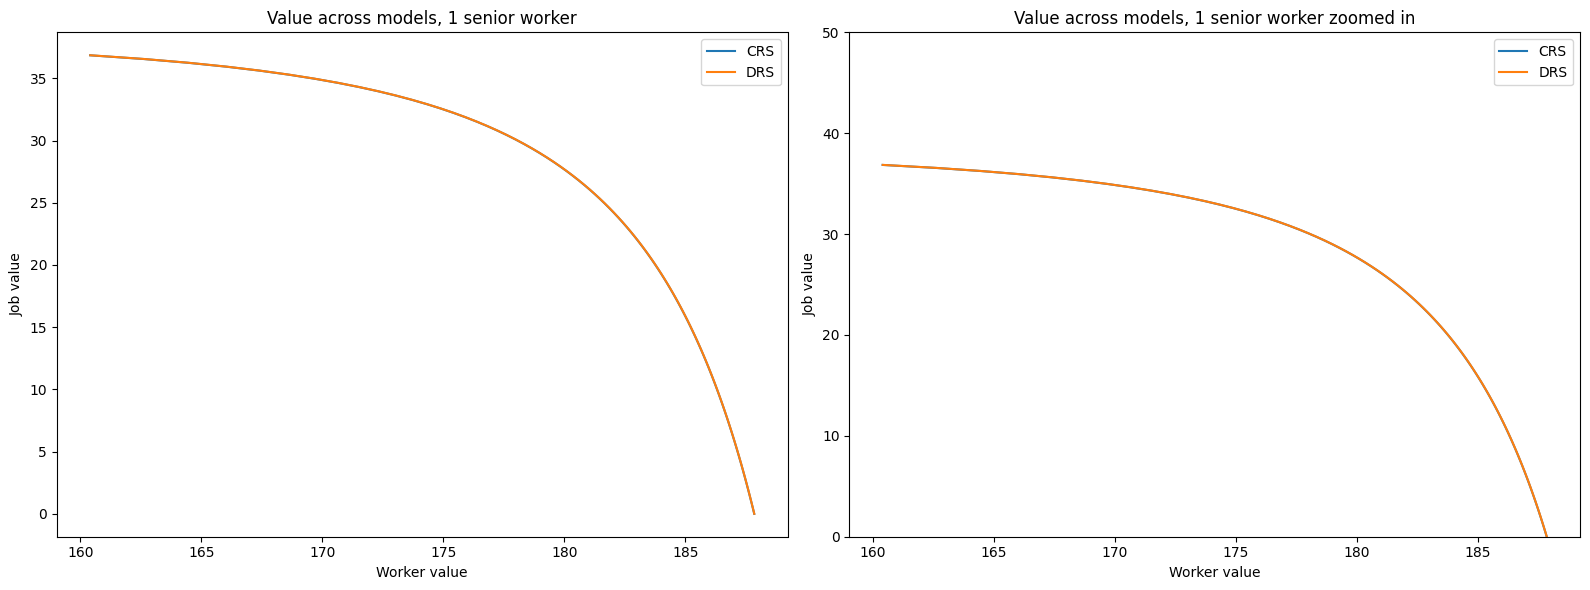

In [4]:
plts.CRSvsDRSvalue(cc_W,cc_J,mwc_W,mwc_J,mwc_s_W,mwc_s_J,mwc_s_dir_W,mwc_s_dir_J,0)

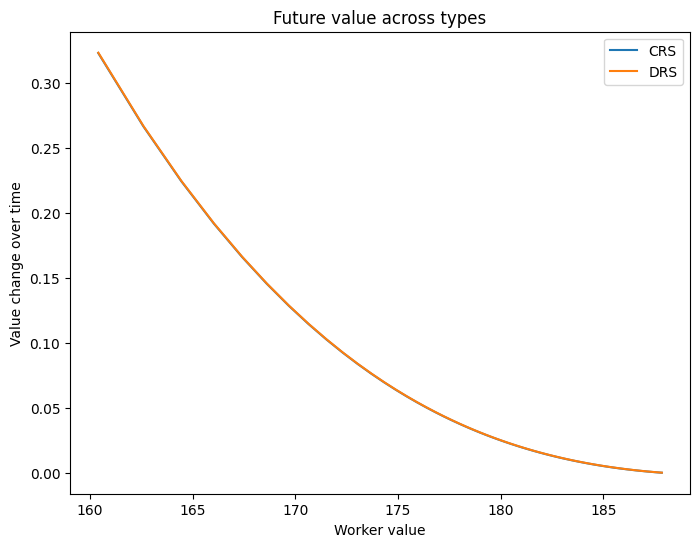

In [5]:
plts.CRSvsDRSpolicy(cc_W,cc_Wstar,mwc_W,mwc_Wstar,mwc_s_W,mwc_s_Wstar,mwc_s_dir_W,mwc_s_dir_Wstar,0)

In [ ]:
plts.ValueComparison(1,0,1,2,cc_W,cc_J,mwc_W,mwc_J,mwc_s_W,mwc_s_J,mwc_s_dir_W,mwc_s_dir_J,0)

In [ ]:
plts.sep(0,p.z_0-1,1,1,1,2,mwc_s_W,mwc_s_sep,mwc_s_dir_W,mwc_s_dir_sep)

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
jun=1
sen=1
if mwc_s_W is not None:        
    plt.plot(mwc_s_W[p.z_0-1, jun, sen, :, 1], mwc_s_sep[p.z_0-1, jun, sen, :], label='DRS with inv sep')
if mwc_s_dir_W is not None:        
    plt.plot(mwc_s_dir_W[p.z_0-1, jun, sen, :, 1], mwc_s_dir_sep[p.z_0-1, jun, sen, :], label='DRS with direct sep')

plt.title(f'Separations across models, {jun} juniors and {sen} seniors')
plt.xlabel('Worker value')
plt.ylabel('Sep rate')
plt.legend()
#Why does the job value rise when separations go to 1?
#Alex: when something strange is arising at the edge of the grid, it might be the extrapolation issue.
#Is there a way to check my intuition? Seems consistent with size and productivity changes

In [ ]:
plts.CRSvsDRSdirect(cc_J,mwc_J,0)

In [ ]:
plts.CRSvsDRSsurplus(cc_J,cc_W,mwc_J,mwc_W,0)

In [ ]:
import matplotlib.pyplot as plt
import os
# Create a directory to save plots
output_dir = 'Plots'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
np.abs(mwc_s_sep[:,:1,:3,:]-mwc_s_dir_sep[:,:1,:3,:]).max()

In [ ]:
np.max(np.abs(mwc_s_sep[:,3,0,:]-mwc_s_dir_sep[:,3,0,:]))

In [ ]:
np.max(mwc_s_dir_sep[:,1,1,:])

In [ ]:
mwc_s_dir_sep[:,1,1,:]

In [ ]:
mwc_s_J[:,1,0,:]/mwc_s_J[:,3,0,:] #this is odd, should be 1/3 exactly, no? it is 1/3 in the case without separations, so why not here? there aren't even any separations!

In [ ]:
np.max(mwc_s_sep[:,3,0,:])

In [ ]:
mwc_s_sep[0,1,1,:] #if the two value functions intersect, then how come the separation rate is 1?
#also thats way too many separations